<a href="https://colab.research.google.com/github/Emma-Ok/Phishing-Detection-ML/blob/main/DimensionReduction/RF_%26_SVM_%26_Features_Selection_Wrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# Constantes
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Definir los conjuntos de características seleccionadas por métodos wrapper
FEATURE_SETS = {
    'SVM_RFECV': {
        'features': [
            'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname',
            'TildeSymbol', 'NumUnderscore', 'NumPercent', 'NumQueryComponents',
            'NumAmpersand', 'NoHttps', 'IpAddress', 'DomainInSubdomains', 'PathLength',
            'QueryLength', 'NumSensitiveWords', 'PctExtHyperlinks', 'PctExtResourceUrls',
            'ExtFavicon', 'InsecureForms', 'RelativeFormAction', 'ExtFormAction',
            'AbnormalFormAction', 'PctNullSelfRedirectHyperlinks',
            'FrequentDomainNameMismatch', 'FakeLinkInStatusBar', 'RightClickDisabled',
            'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle', 'SubdomainLevelRT',
            'UrlLengthRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR',
            'PctExtNullSelfRedirectHyperlinksRT'
        ],
        'count': 35,
        'description': 'SVM con Recursive Feature Elimination CV'
    },
    'SVM_SFS': {
        'features': [
            'PathLevel', 'NumDash', 'NumDashInHostname', 'TildeSymbol', 'NumSensitiveWords',
            'PctExtHyperlinks', 'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
            'AbnormalFormAction', 'PctNullSelfRedirectHyperlinks',
            'FrequentDomainNameMismatch', 'SubmitInfoToEmail', 'IframeOrFrame',
            'PctExtNullSelfRedirectHyperlinksRT'
        ],
        'count': 15,
        'description': 'SVM con Sequential Feature Selection'
    },
    'RF_RFECV': {
        'features': [
            'NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
            'NumDashInHostname', 'TildeSymbol', 'NumUnderscore', 'NumPercent',
            'NumQueryComponents', 'NumAmpersand', 'NumNumericChars', 'NoHttps',
            'RandomString', 'IpAddress', 'DomainInSubdomains', 'DomainInPaths',
            'HostnameLength', 'PathLength', 'QueryLength', 'NumSensitiveWords',
            'EmbeddedBrandName', 'PctExtHyperlinks', 'PctExtResourceUrls', 'ExtFavicon',
            'InsecureForms', 'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
            'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
            'FakeLinkInStatusBar', 'RightClickDisabled', 'SubmitInfoToEmail', 'IframeOrFrame',
            'MissingTitle', 'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT',
            'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT',
            'PctExtNullSelfRedirectHyperlinksRT'
        ],
        'count': 43,
        'description': 'Random Forest con Recursive Feature Elimination CV'
    },
    'RF_SFS': {
        'features': [
            'NumUnderscore', 'NumQueryComponents', 'NoHttps', 'PathLength',
            'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks',
            'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms', 'ExtFormAction',
            'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch', 'PopUpWindow',
            'SubmitInfoToEmail', 'IframeOrFrame'
        ],
        'count': 16,
        'description': 'Random Forest con Sequential Feature Selection'
    }
}

print("=== CARGA DEL DATASET ===")
url = "https://raw.githubusercontent.com/Emma-Ok/Phishing-Detection-ML/main/Phishing_Legitimate_full.csv"
df = pd.read_csv(url).drop(columns=["id"])

print(f"Dataset original: {df.shape[0]} muestras, {df.shape[1] - 1} características")



=== CARGA DEL DATASET ===
Dataset original: 10000 muestras, 48 características


In [ ]:
def evaluate_model_with_features(X, y, feature_set_name, feature_list, test_size=0.2, random_state=42):
    """
    Evalúa tanto Random Forest como SVM con un conjunto específico de características
    """
    print(f"\n" + "="*80)
    print(f"🔍 EVALUANDO CONJUNTO: {feature_set_name}")
    print(f"📋 {FEATURE_SETS[feature_set_name]['description']}")
    print(f"📊 Características: {len(feature_list)}")
    print("="*80)

    # Verificar que las características existen
    available_features = [feat for feat in feature_list if feat in X.columns]
    missing_features = [feat for feat in feature_list if feat not in X.columns]

    if missing_features:
        print(f"⚠️  Características no encontradas: {missing_features}")

    if not available_features:
        print("❌ No se encontraron características válidas para este conjunto")
        return None

    print(f"✅ Características disponibles: {len(available_features)}")

    # Seleccionar características
    X_subset = X[available_features]

    # División de datos
    X_train, X_test, y_train, y_test = train_test_split(
        X_subset, y, stratify=y, test_size=test_size, random_state=random_state
    )

    # Normalización para SVM
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    results = {}

    # =================
    # RANDOM FOREST
    # =================
    print(f"\n🌲 ENTRENANDO RANDOM FOREST...")
    rf_params = {
        'n_estimators': 295,
        'max_depth': 52,
        'min_samples_split': 3,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'bootstrap': False,
        'class_weight': 'balanced
        'random_state': RANDOM_STATE,
        'n_jobs': -1
    }

    rf_model = RandomForestClassifier(**rf_params)
    rf_model.fit(X_train, y_train)

    y_pred_rf = rf_model.predict(X_test)
    y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

    # Métricas RF
    rf_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'precision': precision_score(y_test, y_pred_rf, average='weighted'),
        'recall': recall_score(y_test, y_pred_rf, average='weighted'),
        'f1': f1_score(y_test, y_pred_rf, average='weighted'),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_rf)
    }

    # =================
    # SVM
    # =================
    print(f"🤖 ENTRENANDO SVM...")
    svm_params = {
        'C': 14.403910932208483,
        'kernel': 'rbf',
        'random_state': RANDOM_STATE,
        'probability': True,
        'gamma': 'scale',
        'shrinking': True,
        'class_weight': 'balanced'
    }

    svm_model = SVC(**svm_params)
    svm_model.fit(X_train_scaled, y_train)

    y_pred_svm = svm_model.predict(X_test_scaled)
    y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

    # Métricas SVM
    svm_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_svm),
        'precision': precision_score(y_test, y_pred_svm, average='weighted'),
        'recall': recall_score(y_test, y_pred_svm, average='weighted'),
        'f1': f1_score(y_test, y_pred_svm, average='weighted'),
        'roc_auc': roc_auc_score(y_test, y_pred_proba_svm)
    }

    # Mostrar resultados
    print(f"\n📊 RESULTADOS PARA {feature_set_name}:")
    print(f"{'Métrica':<12} {'Random Forest':<15} {'SVM':<15} {'Mejor':<15}")
    print("-" * 60)

    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    metric_keys = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    for name, key in zip(metrics_names, metric_keys):
        rf_val = rf_metrics[key]
        svm_val = svm_metrics[key]
        mejor = "RF" if rf_val > svm_val else "SVM" if svm_val > rf_val else "Empate"
        star = " ⭐" if key == 'f1' else ""
        print(f"{name + star:<12} {rf_val:<15.4f} {svm_val:<15.4f} {mejor:<15}")

    # Determinar mejor modelo para este conjunto
    mejor_modelo = "Random Forest" if rf_metrics['f1'] > svm_metrics['f1'] else "SVM"
    mejor_f1 = max(rf_metrics['f1'], svm_metrics['f1'])

    print(f"\n🏆 MEJOR MODELO: {mejor_modelo} (F1-Score: {mejor_f1:.4f})")

    # Matrices de confusión
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    cm_svm = confusion_matrix(y_test, y_pred_svm)

    # Visualización lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Random Forest
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Legitimate', 'Phishing'],
                yticklabels=['Legitimate', 'Phishing'])
    axes[0].set_title(f'Random Forest - {feature_set_name}\nF1-Score: {rf_metrics["f1"]:.4f}')
    axes[0].set_xlabel('Predicción')
    axes[0].set_ylabel('Valor Real')

    # SVM
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
                xticklabels=['Legitimate', 'Phishing'],
                yticklabels=['Legitimate', 'Phishing'])
    axes[1].set_title(f'SVM - {feature_set_name}\nF1-Score: {svm_metrics["f1"]:.4f}')
    axes[1].set_xlabel('Predicción')
    axes[1].set_ylabel('Valor Real')

    plt.tight_layout()
    plt.show()

    return {
        'feature_set': feature_set_name,
        'num_features': len(available_features),
        'rf_metrics': rf_metrics,
        'svm_metrics': svm_metrics,
        'mejor_modelo': mejor_modelo,
        'mejor_f1': mejor_f1,
        'available_features': available_features
    }


Distribución de clases: {1: 5000, 0: 5000}

🔍 EVALUANDO CONJUNTO: SVM_RFECV
📋 SVM con Recursive Feature Elimination CV
📊 Características: 29
✅ Características disponibles: 29

🌲 ENTRENANDO RANDOM FOREST...
🤖 ENTRENANDO SVM...

📊 RESULTADOS PARA SVM_RFECV:
Métrica      Random Forest   SVM             Mejor          
------------------------------------------------------------
Accuracy     0.9860          0.9745          RF             
Precision    0.9860          0.9745          RF             
Recall       0.9860          0.9745          RF             
F1-Score ⭐   0.9860          0.9745          RF             
ROC-AUC      0.9990          0.9965          RF             

🏆 MEJOR MODELO: Random Forest (F1-Score: 0.9860)


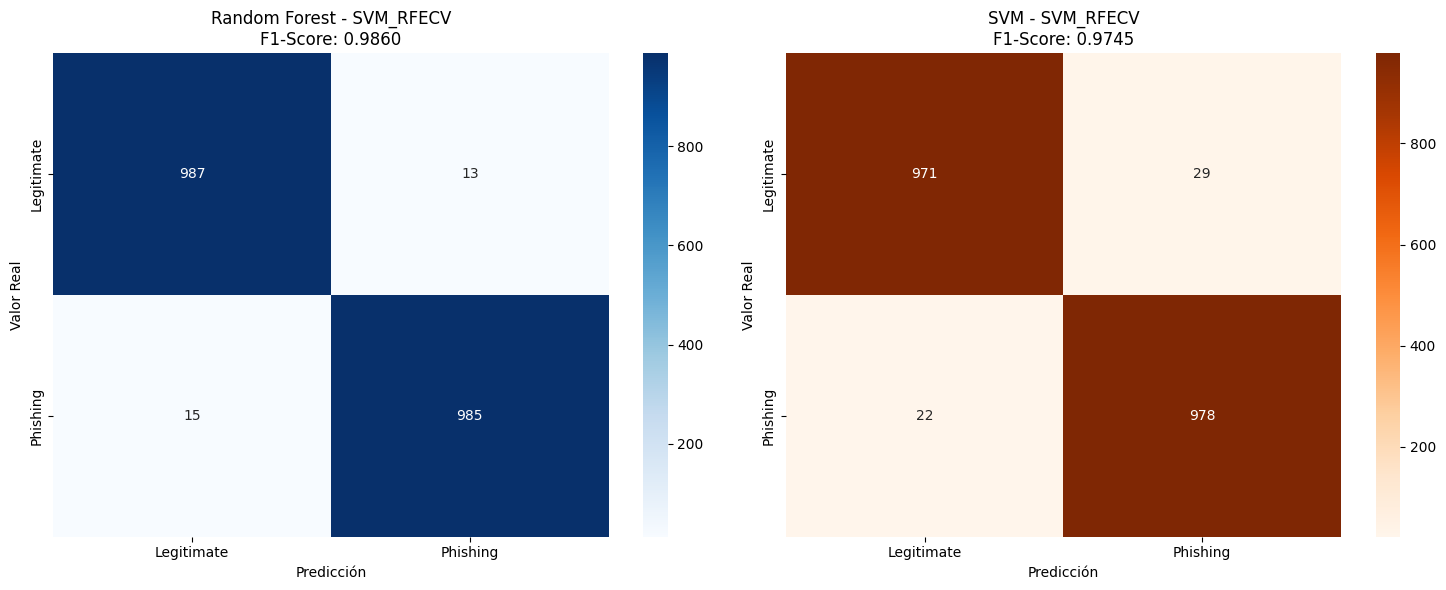


🔍 EVALUANDO CONJUNTO: SVM_SFS
📋 SVM con Sequential Feature Selection
📊 Características: 14
✅ Características disponibles: 14

🌲 ENTRENANDO RANDOM FOREST...
🤖 ENTRENANDO SVM...

📊 RESULTADOS PARA SVM_SFS:
Métrica      Random Forest   SVM             Mejor          
------------------------------------------------------------
Accuracy     0.9645          0.9475          RF             
Precision    0.9648          0.9479          RF             
Recall       0.9645          0.9475          RF             
F1-Score ⭐   0.9645          0.9475          RF             
ROC-AUC      0.9905          0.9830          RF             

🏆 MEJOR MODELO: Random Forest (F1-Score: 0.9645)


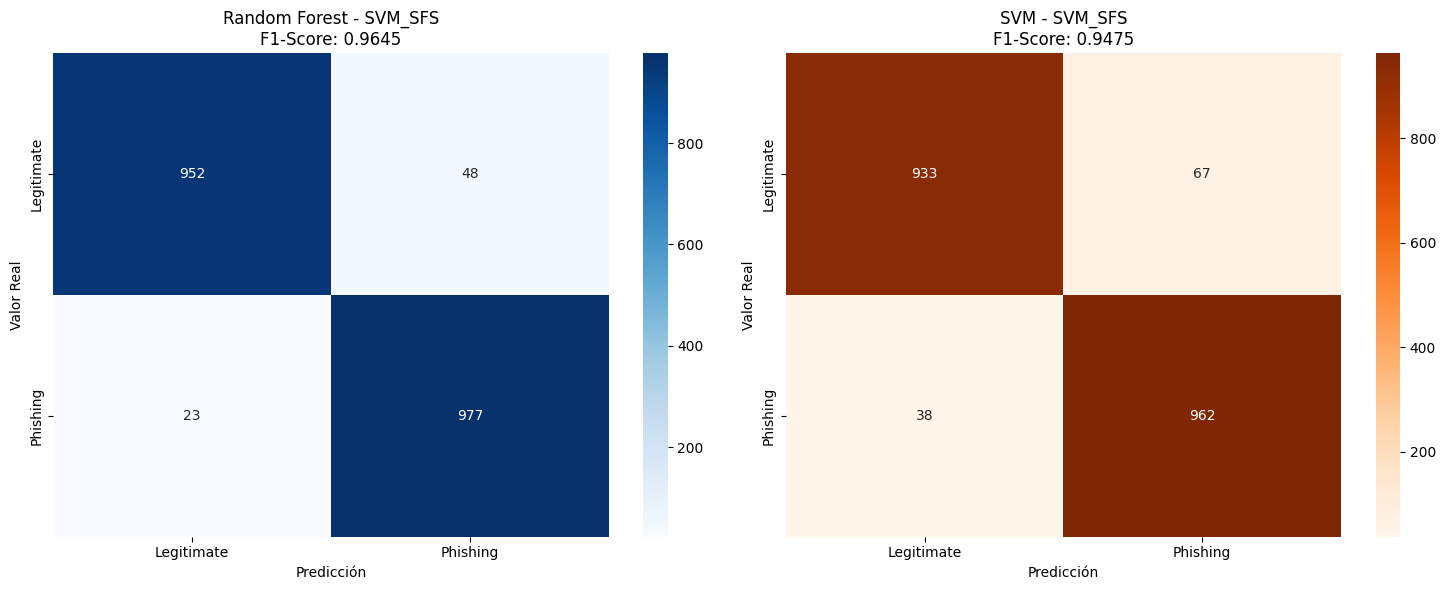


🔍 EVALUANDO CONJUNTO: RF_RFECV
📋 Random Forest con Recursive Feature Elimination CV
📊 Características: 43
✅ Características disponibles: 43

🌲 ENTRENANDO RANDOM FOREST...
🤖 ENTRENANDO SVM...

📊 RESULTADOS PARA RF_RFECV:
Métrica      Random Forest   SVM             Mejor          
------------------------------------------------------------
Accuracy     0.9865          0.9740          RF             
Precision    0.9865          0.9742          RF             
Recall       0.9865          0.9740          RF             
F1-Score ⭐   0.9865          0.9740          RF             
ROC-AUC      0.9991          0.9967          RF             

🏆 MEJOR MODELO: Random Forest (F1-Score: 0.9865)


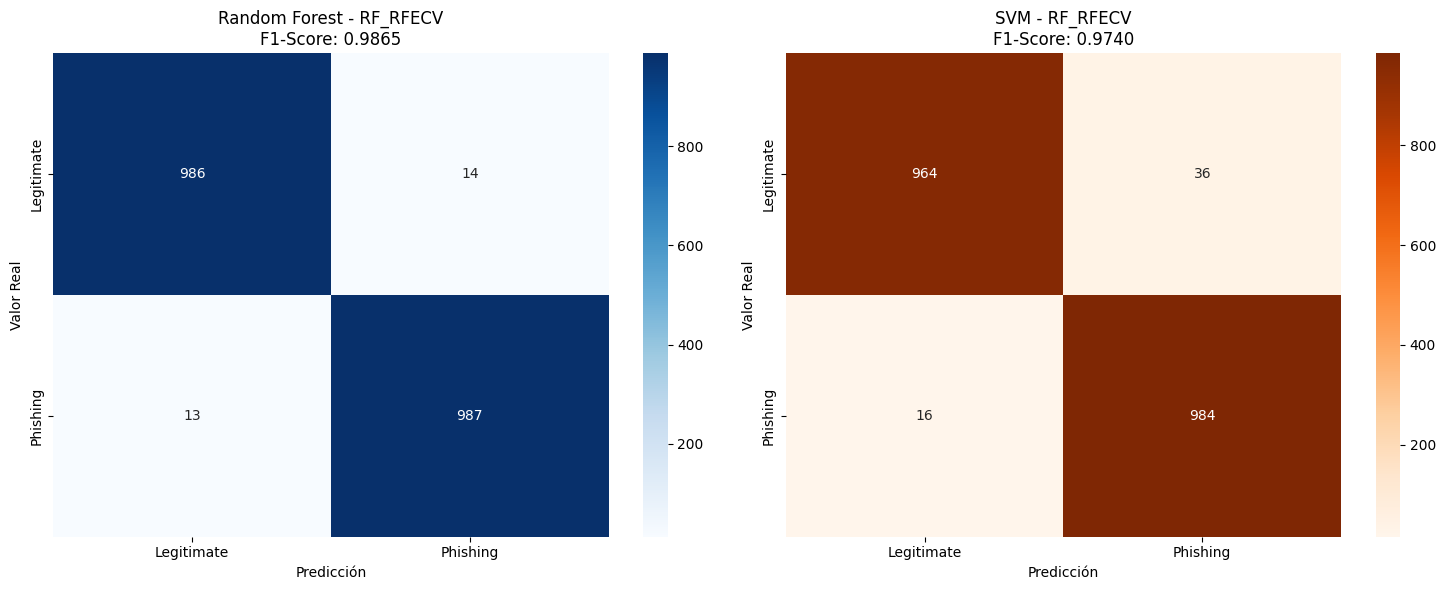


🔍 EVALUANDO CONJUNTO: RF_SFS
📋 Random Forest con Sequential Feature Selection
📊 Características: 19
✅ Características disponibles: 19

🌲 ENTRENANDO RANDOM FOREST...
🤖 ENTRENANDO SVM...

📊 RESULTADOS PARA RF_SFS:
Métrica      Random Forest   SVM             Mejor          
------------------------------------------------------------
Accuracy     0.9775          0.9540          RF             
Precision    0.9775          0.9541          RF             
Recall       0.9775          0.9540          RF             
F1-Score ⭐   0.9775          0.9540          RF             
ROC-AUC      0.9970          0.9882          RF             

🏆 MEJOR MODELO: Random Forest (F1-Score: 0.9775)


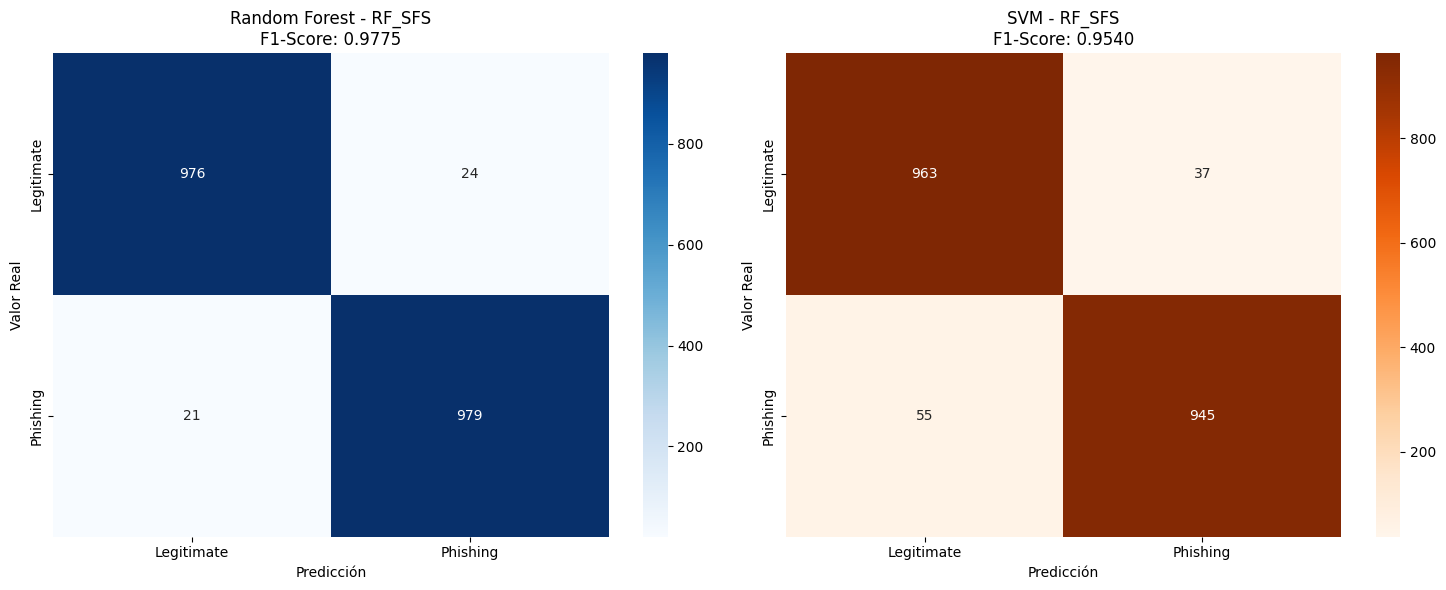


 RESUMEN COMPARATIVO DE TODOS LOS CONJUNTOS

 RANKING DE CONJUNTOS DE CARACTERÍSTICAS (por F1-Score):
 Conjunto  Num_Features  RF_F1  SVM_F1  Mejor_Modelo  Mejor_F1
 RF_RFECV            43 0.9865  0.9740 Random Forest    0.9865
SVM_RFECV            29 0.9860  0.9745 Random Forest    0.9860
   RF_SFS            19 0.9775  0.9540 Random Forest    0.9775
  SVM_SFS            14 0.9645  0.9475 Random Forest    0.9645

🥇 MEJOR CONJUNTO GENERAL:
   Conjunto: RF_RFECV
   Características: 43
   Mejor modelo: Random Forest
   F1-Score: 0.9865


In [ ]:
X = df.drop(columns=["CLASS_LABEL"])
y = df["CLASS_LABEL"]

print(f"Distribución de clases: {y.value_counts().to_dict()}")

# Evaluar cada conjunto de características
all_results = []

for feature_set_name, feature_info in FEATURE_SETS.items():
    result = evaluate_model_with_features(
        X, y, feature_set_name, feature_info['features']
    )
    if result:
        all_results.append(result)

print("\n" + "="*80)
print(" RESUMEN COMPARATIVO DE TODOS LOS CONJUNTOS")
print("="*80)

# Crear tabla resumen
summary_data = []
for result in all_results:
    summary_data.append({
        'Conjunto': result['feature_set'],
        'Num_Features': result['num_features'],
        'RF_F1': result['rf_metrics']['f1'],
        'SVM_F1': result['svm_metrics']['f1'],
        'Mejor_Modelo': result['mejor_modelo'],
        'Mejor_F1': result['mejor_f1']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Mejor_F1', ascending=False)

print("\n RANKING DE CONJUNTOS DE CARACTERÍSTICAS (por F1-Score):")
print(summary_df.round(4).to_string(index=False))

# Mejor conjunto general
mejor_conjunto = summary_df.iloc[0]
print(f"\n🥇 MEJOR CONJUNTO GENERAL:")
print(f"   Conjunto: {mejor_conjunto['Conjunto']}")
print(f"   Características: {mejor_conjunto['Num_Features']}")
print(f"   Mejor modelo: {mejor_conjunto['Mejor_Modelo']}")
print(f"   F1-Score: {mejor_conjunto['Mejor_F1']:.4f}")
